# 포스코 AI·BIG Data 아카데미 22기 A반 김예린

### 종합과제 2 - 후판공정 Scale 불량 영향 인자 분석 및 개선안 프로젝트

In [1008]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot, add_constant
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 환경에서는 'Malgun Gothic' 폰트를 사용
else:
    plt.rcParams['font.family'] = 'AppleGothic'  # macOS나 Linux 등 다른 환경에서는 'AppleGothic' 폰트를 사용

matplotlib.rcParams['axes.unicode_minus'] = False

#### 데이터 불러오기 - scale

In [1009]:
import os
os.chdir(r"C:\Users\zlddp\OneDrive\바탕 화면\project_scale") #current directory 지정
os.getcwd()

'C:\\Users\\zlddp\\OneDrive\\바탕 화면\\project_scale'

In [1012]:
#데이터 불러오기
df_raw = pd.read_csv("SCALE불량.csv", encoding = 'euc-kr')
df_raw

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,PLT_1996,10JAN2023:05:32:25,양품,BV-A,프랑스,C,19,3400,41500,적용,...,1142,55,1151,86,203,1151,CR(제어압연),948,10,4조
996,PLT_1997,10JAN2023:05:39:19,양품,LR-A,영국,C,19,3400,41500,적용,...,1142,55,1151,86,209,1151,CR(제어압연),948,10,4조
997,PLT_1998,10JAN2023:05:52:41,양품,AB/AH32,미국,C,17,3400,43700,적용,...,1169,65,1163,77,227,1163,CR(제어압연),948,10,4조
998,PLT_1999,10JAN2023:06:01:50,양품,NV-A32,영국,C,17,3400,43700,적용,...,1169,65,1163,77,204,1163,CR(제어압연),948,10,4조


#### 데이터 설명
> 목표변수
- scale : 스케일(산화철) 불량 여부를 나타내는 변수,
스케일은 후판에 생기는 산화철 층으로, 스케일이 발생하면 제품의 품질이 저하될 수 있다.

> 설명변수
- plate_no : 제품 번호
- rolling_date : 열연작업시각 -> 참고로 후판압연은 계절/시간적 영향을 받지 않는다. 
- spec_long : 제품 규격(해당 규격은 특정 국가의 기준에 맞춰야 한다.)
- spec_country : 제품 규격의 기준이 되는 국가를 나타내는 변수
- steel_kind : 강종(탄소강, 티타늄강)
                -> 탄소강은 스케일이 잘 생기는 강종이며, 티타늄강은 스케일이 잘 생기지 않는 강종
- pt_thick : 후판 지시 두께
- pt_width : 후판 지시폭
- pt_length : 후판 지시 길이
- hsb : Hot scale Braker(열간 스케일 파쇄기) 적용 여부 -> 열간 스케일 파쇄기는 스케일이 발생하지 않도록 도와주는 장치
- fur_no : 가열로 호기 (가열로 호기마다 같은 제품이지만 미세한 성능의 차이가 보일 수 있음)
- fur_input_row : 가열로 장입열 (가열로에 장입된 열을 나타내는 변수) -> 장입 순서에 가까운 개념
- fur_heat_temp : 가열로의 가열대 소재 온도
- fur_heat_time : 가열로 가열대 재로시간(분)
- fur_soak_temp : 가열로 균열대 소재온도 **
- fur_total_time : 가열로 총 재로시간(분) -> 예열대, 가열대, 균열대의 시간을 합산한 값
- fur_ex_temp : 가열로 추출온도 계산치 (가열로에서 주는 온도와 실제 온도가 다르며, 일정 이상 온도가 갑자기 감소하면 스케일 불량 조건으로 판단될 수 있다.)
- rolling_method : 압연방법 (TMCP, CR) -> 두 방법 모두 스케일을 제거하기 위한 방법
    -> TMCP(Temperature-Mechanical Controlled Processing) / CR(Cold Rolling) 
- rolling_temp : 압연 온도 (압연 과정 동안 유지되는 주변 온도)
- descaling_count : 압연 디스케일링 횟수 (에어건이나 물을 사용하여 스케일을 제거하는 작업) **
- work_group : 작업조 4조 2교대 (07시/19시 기준)

In [905]:
df_raw.info() #데이터 열 정보 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

In [906]:
df_raw.isnull().sum() #데이터 결측값 확인 - 없음

plate_no           0
rolling_date       0
scale              0
spec_long          0
spec_country       0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
hsb                0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
fur_ex_temp        0
rolling_method     0
rolling_temp       0
descaling_count    0
work_group         0
dtype: int64

In [907]:
df_raw['scale'].describe() #목표변수 기술통계량 확인 -> 범주형

count     1000
unique       2
top         양품
freq       690
Name: scale, dtype: object

In [908]:
df_raw.describe() #수치형 변수에 대한 요약통계 

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_temp,descaling_count
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,26.78200,2831.900000,36788.200000,1157.245000,85.972000,1150.928000,71.720000,238.589000,1150.928000,934.637000,8.557000
std,18.13757,494.081478,13912.387116,21.245007,26.346297,17.344384,20.602137,38.194828,17.344384,96.598015,1.604158
min,12.00000,1800.000000,7900.000000,1103.000000,55.000000,1113.000000,35.000000,165.000000,1113.000000,0.000000,5.000000
25%,15.00000,2500.000000,26650.000000,1140.000000,66.000000,1135.750000,57.750000,210.000000,1135.750000,893.750000,8.000000
50%,19.00000,2800.000000,40400.000000,1159.000000,75.000000,1156.000000,66.000000,230.000000,1156.000000,948.000000,9.000000
75%,34.00000,3100.000000,49100.000000,1173.000000,102.250000,1164.000000,81.000000,263.000000,1164.000000,991.000000,10.000000
max,100.00000,4600.000000,54900.000000,1206.000000,158.000000,1185.000000,145.000000,362.000000,1185.000000,1078.000000,10.000000


In [909]:
df_raw.describe(include = 'object') #범주형 변수에 대한 요약통계 

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,hsb,fur_no,fur_input_row,rolling_method,work_group
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,1000,2,66,7,2,2,3,2,2,4
top,PLT_1001,03JAN2023:07:07:53,양품,JS-SM490YB,영국,C,적용,3호기,1열,CR(제어압연),2조
freq,1,1,690,84,256,755,953,342,508,840,292


#### 그래프로 이상치 확인

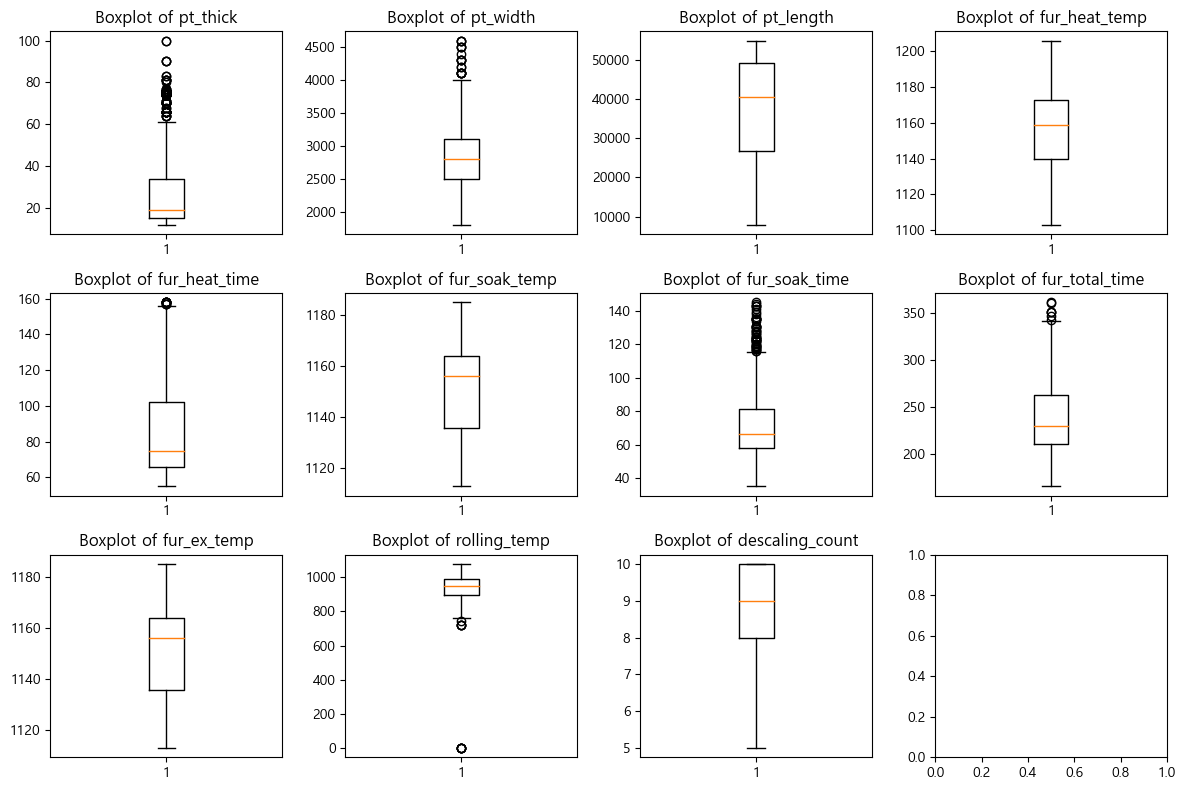

In [910]:
# 이상치 확인
variables = ['pt_thick', 'pt_width', 'pt_length', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'fur_soak_time',
             'fur_total_time', 'fur_ex_temp', 'rolling_temp', 'descaling_count']

# Boxplot
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))  # 3행 4열의 subplot 생성
axes = axes.flatten()  # 2차원 배열을 1차원으로 펼치기

for i, variable in enumerate(variables):
    axes[i].boxplot(df_raw[variable])
    axes[i].set_title(f"Boxplot of {variable}")

# subplot 간 간격 조정
plt.tight_layout()

# 그래프 출력
plt.show()

위 boxplot에서 rolling_temp(압연 온도)에서 이상치가 발견되었다.  
*참고 : rolling_temp (압연 과정 동안 유지되는 주변 온도)

온도가 아무리 낮아도 압연 과정의 철 온도는 0도 이상일거라 생각한다.

In [911]:
df_raw['rolling_temp'].describe() #rolling_temp 데이터 기술 통계량 확인

count    1000.000000
mean      934.637000
std        96.598015
min         0.000000
25%       893.750000
50%       948.000000
75%       991.000000
max      1078.000000
Name: rolling_temp, dtype: float64

In [912]:
df_raw[df_raw['rolling_temp'] == 0.000000]

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
53,PLT_1054,03JAN2023:16:22:29,양품,GL-E36-TM,독일,T,56,3800,11400,적용,...,1132,95,1128,80,244,1128,TMCP(온도제어),0,6,1조
221,PLT_1222,04JAN2023:19:44:09,양품,JS-SM490YB,일본,C,16,2200,43600,적용,...,1163,57,1166,67,228,1166,CR(제어압연),0,10,2조
222,PLT_1223,04JAN2023:19:56:39,양품,JS-SM490YB,일본,C,16,2200,43600,적용,...,1169,64,1164,61,188,1164,CR(제어압연),0,10,2조
598,PLT_1599,07JAN2023:11:40:51,양품,PILAC-BT33,한국,T,81,2100,12900,적용,...,1133,89,1122,59,229,1122,CR(제어압연),0,6,3조
599,PLT_1600,07JAN2023:11:52:00,양품,PILAC-BT33,한국,T,81,2100,13200,적용,...,1130,92,1124,61,210,1124,CR(제어압연),0,6,3조
600,PLT_1601,07JAN2023:11:59:10,양품,NV-D32-TM,영국,T,40,2500,23600,적용,...,1119,109,1117,76,260,1117,TMCP(온도제어),0,6,3조


rolling_temp가 0도인 데이터가 6개 발견되었다. </br>
동일한 제품 규격(spec_long)을 가지는 데이터들을 찾아, 그 변수들의 평균값으로 대체하기로 결정했다.

In [913]:
df_raw[df_raw['spec_long'] == 'GL-E36-TM'].head(3) #GL-E36-TM

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
26,PLT_1027,03JAN2023:11:37:34,양품,GL-E36-TM,독일,T,44,2000,27500,적용,...,1114,64,1120,82,240,1120,TMCP(온도제어),836,6,1조
27,PLT_1028,03JAN2023:11:44:48,양품,GL-E36-TM,독일,T,44,2000,27500,적용,...,1113,124,1120,82,276,1120,TMCP(온도제어),832,6,1조
28,PLT_1029,03JAN2023:11:59:39,양품,GL-E36-TM,독일,T,48,2100,24500,적용,...,1118,71,1124,86,216,1124,TMCP(온도제어),832,6,1조


In [914]:
df_raw[df_raw['spec_long'] == 'GL-E36-TM']['rolling_temp'].mean()

789.8125

In [915]:
df_raw[df_raw['spec_long'] == 'JS-SM490YB'].head(3)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
121,PLT_1122,04JAN2023:03:42:56,양품,JS-SM490YB,일본,C,14,3300,51200,적용,...,1140,80,1131,117,286,1131,CR(제어압연),915,10,2조
122,PLT_1123,04JAN2023:03:50:27,양품,JS-SM490YB,일본,C,14,3300,51200,적용,...,1142,74,1132,123,284,1132,CR(제어압연),923,10,2조
123,PLT_1124,04JAN2023:03:58:56,양품,JS-SM490YB,일본,C,14,3300,51200,적용,...,1142,75,1131,122,284,1131,CR(제어압연),913,10,2조


In [916]:
df_raw[df_raw['spec_long'] == 'JS-SM490YB']['rolling_temp'].mean()

955.6190476190476

In [917]:
df_raw[df_raw['spec_long'] == 'PILAC-BT33'].head(3)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
551,PLT_1552,07JAN2023:03:22:46,양품,PILAC-BT33,한국,T,40,2500,16900,적용,...,1165,112,1122,135,333,1122,CR(제어압연),910,6,2조
552,PLT_1553,07JAN2023:03:34:39,양품,PILAC-BT33,한국,T,40,1800,18900,적용,...,1170,105,1117,135,338,1117,CR(제어압연),906,6,2조
553,PLT_1554,07JAN2023:03:49:31,양품,PILAC-BT33,한국,T,50,1800,24900,적용,...,1169,111,1129,122,299,1129,CR(제어압연),891,6,2조


In [918]:
df_raw[df_raw['spec_long'] == 'PILAC-BT33']['rolling_temp'].mean()

841.325

In [919]:
df_raw[df_raw['spec_long'] == 'NV-D32-TM'].head(3)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
533,PLT_1534,07JAN2023:00:22:33,양품,NV-D32-TM,영국,T,40,2100,26500,적용,...,1173,92,1138,80,274,1138,TMCP(온도제어),895,6,2조
562,PLT_1563,07JAN2023:05:20:25,양품,NV-D32-TM,영국,T,40,2000,28900,적용,...,1135,106,1121,126,322,1121,TMCP(온도제어),887,6,2조
563,PLT_1564,07JAN2023:05:29:47,양품,NV-D32-TM,영국,T,40,2000,28900,적용,...,1158,106,1124,124,298,1124,TMCP(온도제어),891,6,2조


In [920]:
df_raw[df_raw['spec_long'] == 'NV-D32-TM']['rolling_temp'].mean()

668.25

In [921]:
# 이상치 값을 평균 값으로 채우기
df_raw[df_raw['plate_no'] == 'PLT_1054']['rolling_temp'].replace(0, 789.8125)
df_raw[df_raw['plate_no'] == 'PLT_1222']['rolling_temp'].replace(0, 955.6190476190476) #PLT_1222와 PLT_1223은 동일 제품규격을 가짐
df_raw[df_raw['plate_no'] == 'PLT_1223']['rolling_temp'].replace(0, 955.6190476190476)
df_raw[df_raw['plate_no'] == 'PLT_1599']['rolling_temp'].replace(0, 841.325) #PLT_1599와 PLT1600은 동일 제품규격을 가짐
df_raw[df_raw['plate_no'] == 'PLT_1600']['rolling_temp'].replace(0, 841.325)
df_raw[df_raw['plate_no'] == 'PLT_1601']['rolling_temp'].replace(0, 668.25)

600    668.25
Name: rolling_temp, dtype: float64

In [922]:
df_raw[df_raw['rolling_temp'] == 0.000000]

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
53,PLT_1054,03JAN2023:16:22:29,양품,GL-E36-TM,독일,T,56,3800,11400,적용,...,1132,95,1128,80,244,1128,TMCP(온도제어),0,6,1조
221,PLT_1222,04JAN2023:19:44:09,양품,JS-SM490YB,일본,C,16,2200,43600,적용,...,1163,57,1166,67,228,1166,CR(제어압연),0,10,2조
222,PLT_1223,04JAN2023:19:56:39,양품,JS-SM490YB,일본,C,16,2200,43600,적용,...,1169,64,1164,61,188,1164,CR(제어압연),0,10,2조
598,PLT_1599,07JAN2023:11:40:51,양품,PILAC-BT33,한국,T,81,2100,12900,적용,...,1133,89,1122,59,229,1122,CR(제어압연),0,6,3조
599,PLT_1600,07JAN2023:11:52:00,양품,PILAC-BT33,한국,T,81,2100,13200,적용,...,1130,92,1124,61,210,1124,CR(제어압연),0,6,3조
600,PLT_1601,07JAN2023:11:59:10,양품,NV-D32-TM,영국,T,40,2500,23600,적용,...,1119,109,1117,76,260,1117,TMCP(온도제어),0,6,3조


In [923]:
# 이상치 값을 평균 값으로 채우기
df_raw.loc[df_raw['plate_no'] == 'PLT_1054', 'rolling_temp'] = df_raw[df_raw['plate_no'] == 'PLT_1054']['rolling_temp'].replace(0, 789.8125)
df_raw.loc[df_raw['plate_no'].isin(['PLT_1222', 'PLT_1223']), 'rolling_temp'] = df_raw[df_raw['plate_no'].isin(['PLT_1222', 'PLT_1223'])]['rolling_temp'].replace(0, 955.6190476190476)
df_raw.loc[df_raw['plate_no'].isin(['PLT_1599', 'PLT_1600']), 'rolling_temp'] = df_raw[df_raw['plate_no'].isin(['PLT_1599', 'PLT_1600'])]['rolling_temp'].replace(0, 841.325)
df_raw.loc[df_raw['plate_no'] == 'PLT_1601', 'rolling_temp'] = df_raw[df_raw['plate_no'] == 'PLT_1601']['rolling_temp'].replace(0, 668.25)

In [924]:
df_raw[df_raw['rolling_temp'] == 0.000000] #rollng_temp 0인 값(이상치)들이 제거되었다.

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group


In [925]:
df_raw[df_raw['plate_no'] == 'PLT_1054']['rolling_temp'] #평균값으로 잘 대체되었는지 확인

53    789.8125
Name: rolling_temp, dtype: float64

In [926]:
df_raw['rolling_temp'].describe() # rolling_temp 데이터 기술 통계량 확인

count    1000.000000
mean      939.688951
std        64.571243
min       668.250000
25%       894.000000
50%       948.000000
75%       991.000000
max      1078.000000
Name: rolling_temp, dtype: float64

#### 목표변수 Scale 그래프

In [927]:
df_raw['scale'].value_counts()

scale
양품    690
불량    310
Name: count, dtype: int64

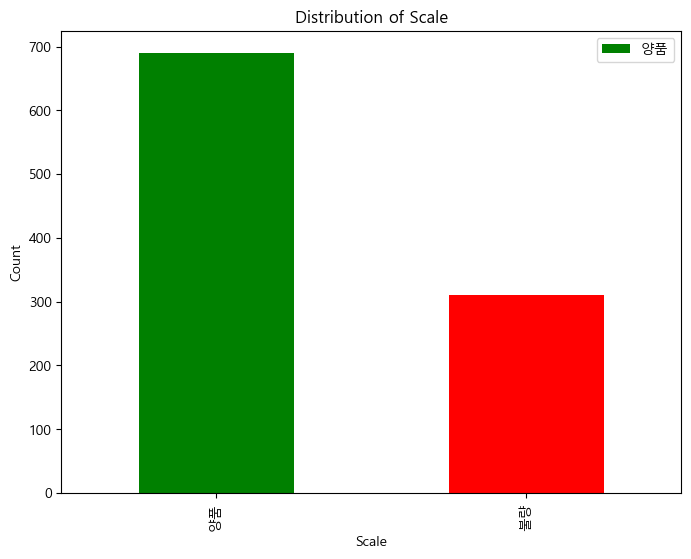

In [928]:
# 목표변수 scale값에 따른 빈도수 계산
scale_counts = df_raw['scale'].value_counts()

# 양품과 불량의 색상 설정
colors = ['green', 'red']

# 막대 그래프 그리기
plt.figure(figsize=(8, 6))
scale_counts.plot(kind='bar', color=colors)

# 범례 추가
plt.legend(labels=scale_counts.index)

plt.xlabel('Scale')
plt.ylabel('Count')
plt.title('Distribution of Scale')
plt.show()

#### scale과 직접적으로 관련이 없는 변수 1차 제거
1. plate_no : 제품 번호 -> 제품번호는 Scale에 영향을 미치지 않을 것으로 판단
2. spec_long : 제품 규격 -> 제품규격은 종류가 많아서 Scale에 영향을 미치지 않을 것으로 판단
3. spec_country : 제품 규격의 기준이 되는 국가를 나타내는 변수

rolling_date도 직접적으로 관련이 없어보이지만, work_group과 연관이 있을 수 있다 판단하여 일단은 나두기로 결정

In [929]:
df_raw.drop(columns=['plate_no', 'spec_long', 'spec_country'], inplace=True)

In [930]:
df_raw.head() #위 세 가지 변수가 제거됐음을 확인가능

,rolling_date,scale,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,03JAN2023:07:07:53,양품,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,1133,TMCP(온도제어),934.0,8,1조
1,03JAN2023:07:21:22,양품,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,1135,TMCP(온도제어),937.0,8,1조
2,03JAN2023:07:31:15,양품,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,1121,TMCP(온도제어),889.0,8,1조
3,03JAN2023:07:41:01,양품,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,1127,TMCP(온도제어),885.0,8,1조
4,03JAN2023:07:52:40,양품,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,1128,TMCP(온도제어),873.0,8,1조


#### 설명변수 Dtype 변경

In [931]:
df_raw['scale'] = df_raw['scale'].map(lambda x : 0 if x == '양품' else 1) #양품을 0, 불량을 1로 매핑
df_raw['scale'].head()

0    0
1    0
2    0
3    0
4    0
Name: scale, dtype: int64

#### 목표변수 Unique값 확인 후 Dtype 변경

In [932]:
#T = 1, C = 2
df_raw['steel_kind'].unique()

array(['T', 'C'], dtype=object)

In [933]:
# steel_kind 변수 값 변환 및 데이터 타입 변경
df_raw['steel_kind'] = df_raw['steel_kind'].map({'T': 1, 'C': 2}).astype(int)

----

In [934]:
#적용 = 1, 미적용 = 2
df_raw['hsb'].unique()

array(['적용', '미적용'], dtype=object)

In [935]:
# hsb 변수 값 변환 및 데이터 타입 변경
df_raw['hsb'] = df_raw['hsb'].map({'적용': 1, '미적용': 2}).astype(int)

----

In [936]:
#1호기 = 1, 2호기 = 2, 3호기 = 3
df_raw['fur_no'].unique()

array(['1호기', '2호기', '3호기'], dtype=object)

In [937]:
# fur_no 변수 값 변환 및 데이터 타입 변경
df_raw['fur_no'] = df_raw['fur_no'].map({'1호기': 1, '2호기': 2, '3호기': 3}).astype(int)

----

In [938]:
#1열 = 1, 2열 = 2
df_raw['fur_input_row'].unique()

array(['1열', '2열'], dtype=object)

In [939]:
# fur_input_row 변수 값 변환 및 데이터 타입 변경
df_raw['fur_input_row'] = df_raw['fur_input_row'].map({'1열': 1, '2열': 2}).astype(int)

----

In [940]:
#TMCP = 1, CR = 2
df_raw['rolling_method'].unique()

array(['TMCP(온도제어)', 'CR(제어압연)'], dtype=object)

In [941]:
import re

# rolling_method 변수 값에서 기호와 문자열 삭제
df_raw['rolling_method'] = df_raw['rolling_method'].apply(lambda x: re.sub(r'\W.*$', '', x)) 
# rolling_method 변수 값 변환 및 데이터 타입 변경
df_raw['rolling_method'] = df_raw['rolling_method'].replace({'TMCP': 1, 'CR': 2}).astype(int)

----

In [942]:
#1조 = 1, 2조 = 2, 3조 = 3, 4조 = 4
df_raw['work_group'].unique()

array(['1조', '2조', '3조', '4조'], dtype=object)

In [943]:
# work_group 변수 값 변환 및 데이터 타입 변경
df_raw['work_group'] = df_raw['work_group'].replace({'1조': 1, '2조': 2, '3조': 3, '4조': 4}).astype(int)

----

In [944]:
df_raw.head() 

,rolling_date,scale,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,03JAN2023:07:07:53,0,1,32,3700,15100,1,1,1,1144,116,1133,59,259,1133,1,934.0,8,1
1,03JAN2023:07:21:22,0,1,32,3700,15100,1,1,2,1144,122,1135,53,238,1135,1,937.0,8,1
2,03JAN2023:07:31:15,0,1,33,3600,19200,1,2,1,1129,116,1121,55,258,1121,1,889.0,8,1
3,03JAN2023:07:41:01,0,1,33,3600,19200,1,2,2,1152,125,1127,68,266,1127,1,885.0,8,1
4,03JAN2023:07:52:40,0,1,38,3100,13300,1,3,1,1140,134,1128,48,246,1128,1,873.0,8,1


In [945]:
df_raw.info() #데이터통계량과 열정보확인을 통해 잘 변경된 것을 확인가능

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rolling_date     1000 non-null   object 
 1   scale            1000 non-null   int64  
 2   steel_kind       1000 non-null   int32  
 3   pt_thick         1000 non-null   int64  
 4   pt_width         1000 non-null   int64  
 5   pt_length        1000 non-null   int64  
 6   hsb              1000 non-null   int32  
 7   fur_no           1000 non-null   int32  
 8   fur_input_row    1000 non-null   int32  
 9   fur_heat_temp    1000 non-null   int64  
 10  fur_heat_time    1000 non-null   int64  
 11  fur_soak_temp    1000 non-null   int64  
 12  fur_soak_time    1000 non-null   int64  
 13  fur_total_time   1000 non-null   int64  
 14  fur_ex_temp      1000 non-null   int64  
 15  rolling_method   1000 non-null   int32  
 16  rolling_temp     1000 non-null   float64
 17  descaling_count

#### 그래프를 통한 탐색적 분석

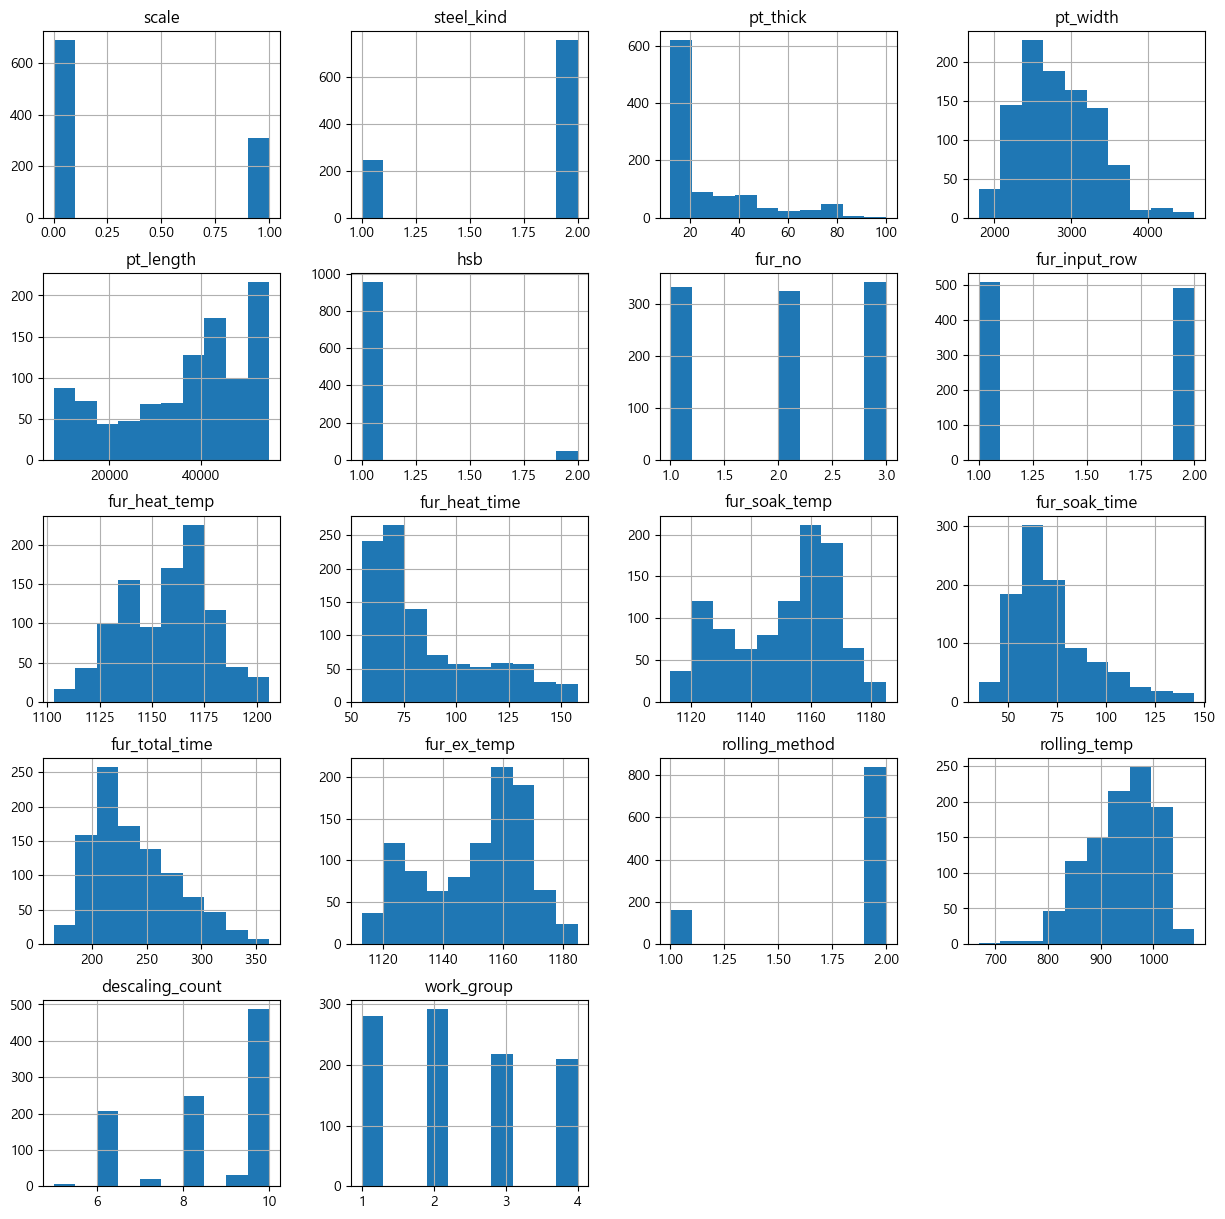

In [946]:
df_raw.hist(figsize = (15, 15)) # 히스토그램 - 데이터의 전반적인 분포를 파악
fig.subplots_adjust(wspace=1.5, hspace=1.5) # 그래프 간격 조절

설명변수들의 데이터의 분포 확인 -> 특별한 이상치는 보이지 않는다.

#### 변수 간 상관 관계 파악 - Pair plot(산점도 행렬)

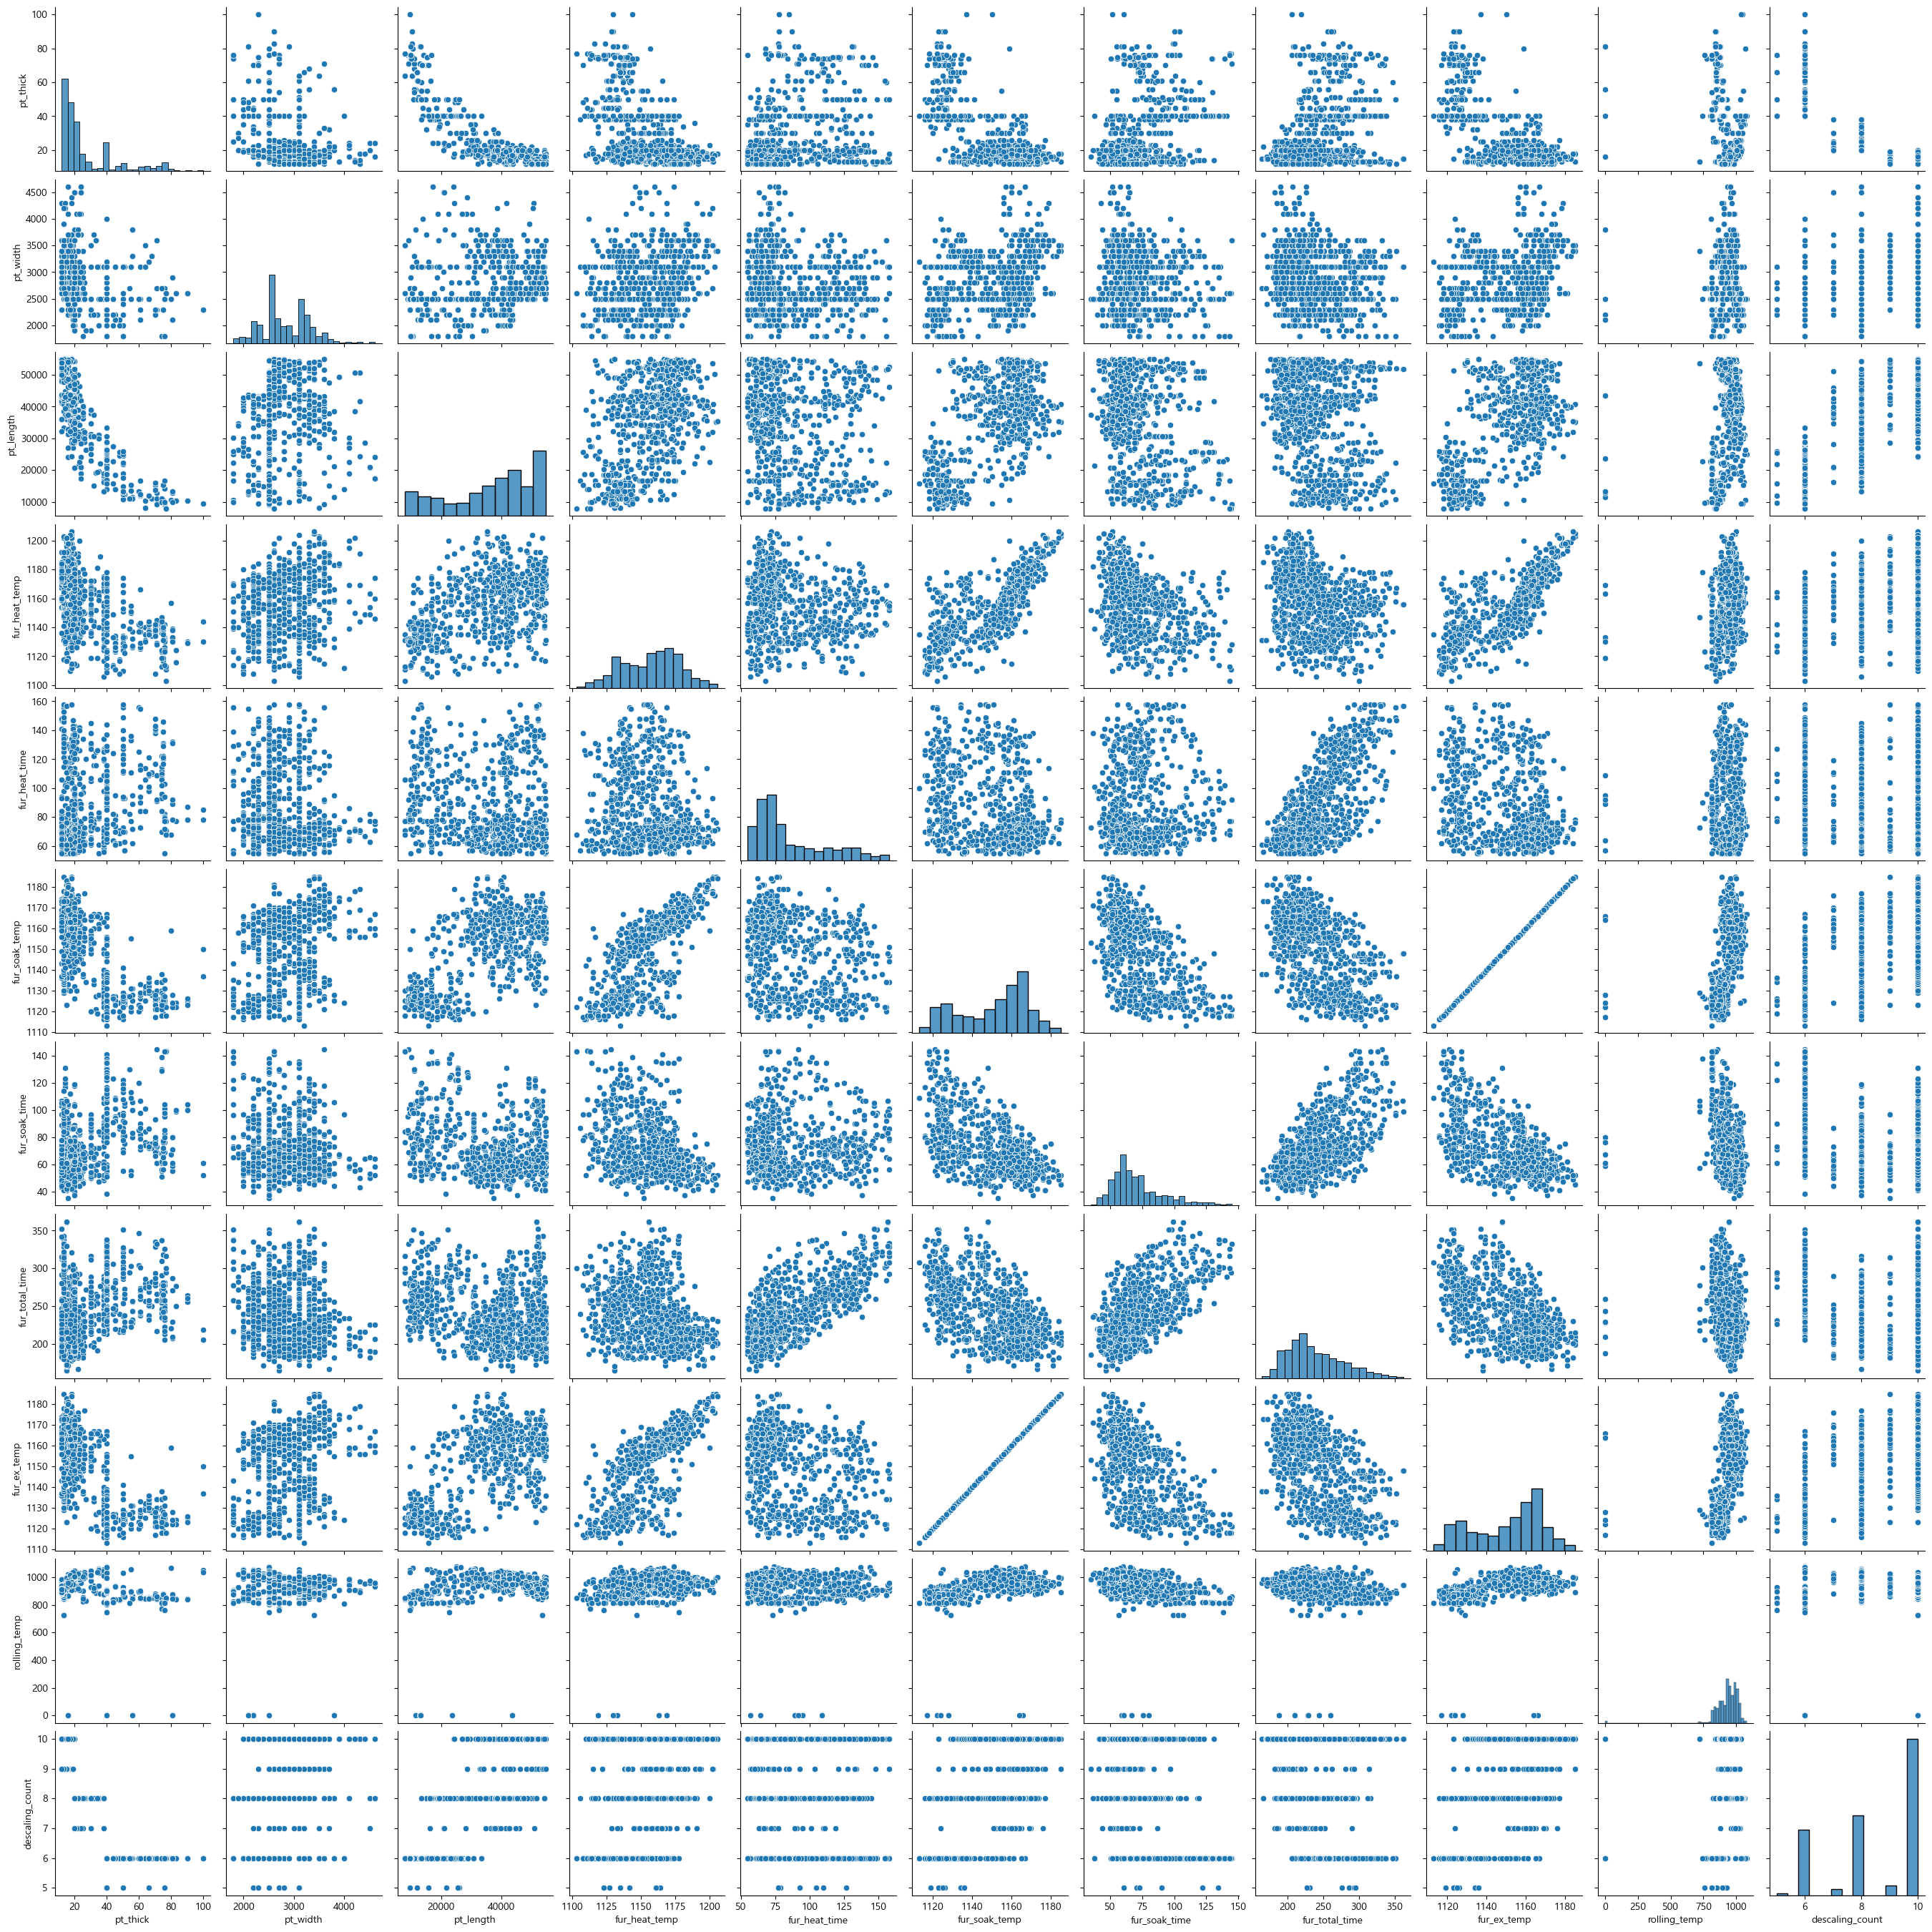

In [1013]:
variables = ['scale', 'steel_kind', 'pt_thick', 'pt_width', 'pt_length',
             'hsb', 'fur_no', 'fur_input_row', 'fur_heat_temp', 'fur_heat_time',
             'fur_soak_temp', 'fur_soak_time', 'fur_total_time', 'fur_ex_temp',
             'rolling_method', 'rolling_temp', 'descaling_count', 'work_group']

sns.pairplot(df_raw[variables])
plt.show()

위 산점도에서 fur_soak_temp(가열로 균열대 소재온도)와 fur_ex_temp(가열로 추출온도)간 강한 선형관계가 나타나는 그래프가 그려졌다. </br>
따라서 두 변수 간의 선형 관계를 시각적으로 다시 확인해보려 한다.

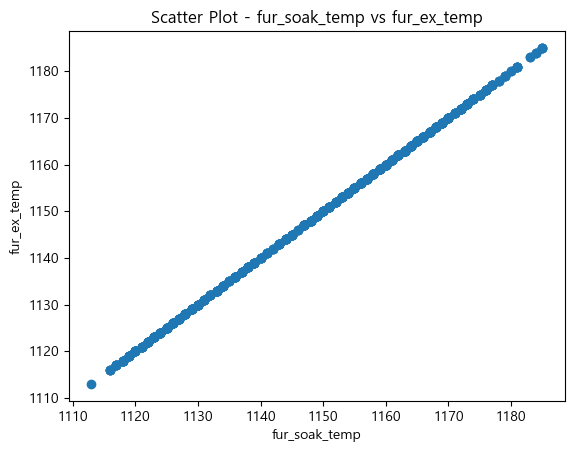

In [948]:
plt.scatter(df_raw['fur_soak_temp'], df_raw['fur_ex_temp'])
plt.xlabel('fur_soak_temp')
plt.ylabel('fur_ex_temp')
plt.title('Scatter Plot - fur_soak_temp vs fur_ex_temp')
plt.show()

위 산점도 그래프에서 두 변수들이 양의 선형 관계를 가지는 것으로 보인다. </br>
즉, 가열로 균열대 소재온도가 높아짐에 따라 가열로 추출온도도 상승하는 것으로 예상된다. </br>

강한 선형관계는 한 변수가 증가할 때 다른 변수도 영향을 받을 수 있으므로, </br>
Heatmap을 통해 변수들 간의 상관 관계를 다시 살펴보고 적절한 조치를 취하려 한다.

In [949]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rolling_date     1000 non-null   object 
 1   scale            1000 non-null   int64  
 2   steel_kind       1000 non-null   int32  
 3   pt_thick         1000 non-null   int64  
 4   pt_width         1000 non-null   int64  
 5   pt_length        1000 non-null   int64  
 6   hsb              1000 non-null   int32  
 7   fur_no           1000 non-null   int32  
 8   fur_input_row    1000 non-null   int32  
 9   fur_heat_temp    1000 non-null   int64  
 10  fur_heat_time    1000 non-null   int64  
 11  fur_soak_temp    1000 non-null   int64  
 12  fur_soak_time    1000 non-null   int64  
 13  fur_total_time   1000 non-null   int64  
 14  fur_ex_temp      1000 non-null   int64  
 15  rolling_method   1000 non-null   int32  
 16  rolling_temp     1000 non-null   float64
 17  descaling_count

<Axes: >

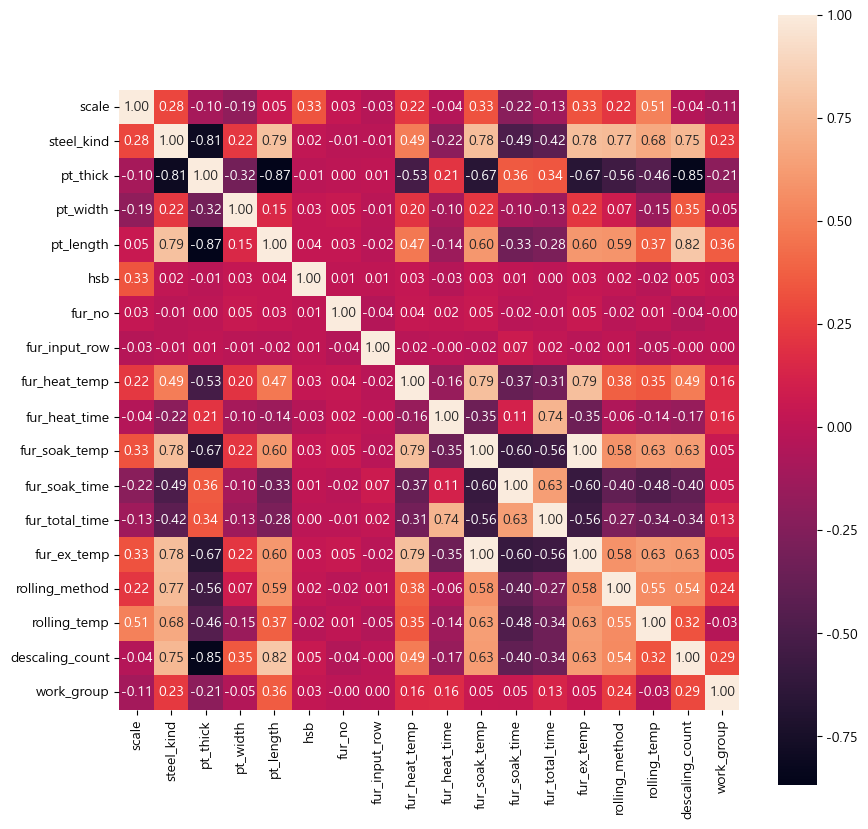

In [950]:
df_numeric = df_raw.select_dtypes(include=np.number) # 수치형 열만 선택하여 새로운 DataFrame 생성
plt.figure(figsize=(10, 10))
sns.heatmap(df_numeric.corr(), annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
#annot=True는 히트맵 셀에 상관계수 값을 표시, square=True는 히트맵 셀을 정사각형 모양으로 표시하도록 지정, annot_kws={'size': 10}는 상관계수 값의 텍스트 크기를 10으로 지정

위 Heatmap에서 fur_soak_temp(가열로 균열대 소재온도)와 fur_ex_temp(가열로 추출온도) 사이 상관계수가 1로 나타났다. </br>
즉, 가열로의 작업 조건에 따라 균열대 소재와 추출 온도 간에 상호 영향 관계가 있다는 것을 의미한다.</br>

다른 변수들간의 상관관계도 살펴보자.</br>
1. pt_thick와 pt_length 또는 pt_width의 음의 상관 관계가 나타난다. </br>
-> 강재의 두께가 증가하면 길이와 폭이 일반적으로 감소하는 경향</br>
2. pt_thick와 descaling_count의 음의 상관 관계가 나타난다. </br>
-> 이 결과를 바탕으로 두꺼운 강재는 일반적으로 Descaling 작업이 더 적게 필요할 수 있다고 예측할 수 있다.</br>
3. 위와 반대로 pt_length와 descaling_count 또는 pt_width와 descaling_count의 강한 양의 상관 관계가 나타난다.</br>
-> 즉, 큰 크기의 제품이나 더 두꺼운 제품은 보다 많은 descaling 작업을 필요로 할 수 있다고 예측할 수 있다.

위 모든 종합적인 결과를 바탕으로 fur_soak_temp(가열로 균열대 소재온도)와 fur_ex_temp(가열로 추출온도) 두 변수 중 하나를 제거하기로 결정했다. </br>
-> 완전한 양의 선형 관계를 띈다는 것은 모델 구축 시 다중공선성 문제가 발생할 수 있기 때문이다.</br>

두 변수 중 하나를 제거하기 위해 관련 도메인 지식을 검색해본 결과 fur_ex_temp(가열로 추출온도)를 제거하기로 결정했다.</br>
먼저, 가열로 균열대 온도는 철강판이 가열로에서 가열되는 과정에서 균열 형성 및 성장을 제어하는 중요한 변수라 한다.</br>
균열은 철강판 표면에서 발생하는 용접 부분의 소성, 산화, 단열물질의 불완전 탈락 등으로 인해 발생할 수 있으며, 이는 Scale 불량의 주요 원인 중 하나라 한다.</br>

반면, 가열로 추출 온도는 가열로에서의 가열 과정이 완료된 후 철강판이 가열로에서 추출되는 시점에서의 온도를 의미한다고 한다.</br>
가열로 추출 온도는 철강판의 열처리 결과에도 영향을 미치지만, Scale 불량 발생에 직접적으로 영향을 주는 요소는 아니라 한다.</br>
또 가열로 추출 온도는 주로 철강판의 최종 온도를 나타내며, 이는 후속 공정이나 제품의 품질에 영향을 줄 수 있다고 밝혀져</br>
scale 불량 발생에 직접적으로 연관된 요소는 아니라하여 fur_ex_temp(가열로 추출온도)를 제거하기로 결정했다.

In [951]:
df_raw.drop('fur_ex_temp', axis=1, inplace=True) #fur_ex_temp 열 제거

#### 카이제곱 검정 - 목표변수(범주형)와 설명변수(범주형) 간의 관계를 파악

In [952]:
from scipy.stats import chi2_contingency

categorical_var = ['steel_kind', 'hsb', 'fur_no', 'work_group', 'descaling_count']

for var in categorical_var:
    contingency_table = pd.crosstab(df_raw[var], df_raw['scale'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(f"Variable: {var}")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p_value}")
    print("\n")

Variable: steel_kind
Chi-square statistic: 77.7104243330205
P-value: 1.1931000837493562e-18


Variable: hsb
Chi-square statistic: 106.41339373625459
P-value: 5.985184936341571e-25


Variable: fur_no
Chi-square statistic: 2.8191975043676525
P-value: 0.24424126476877586


Variable: work_group
Chi-square statistic: 13.84622170632565
P-value: 0.0031221225267359233


Variable: descaling_count
Chi-square statistic: 216.08545929259245
P-value: 1.0242624048898912e-44




위 카이제곱 검정의 결과에서  steel_kind와 hsb, work_group, descaling_count는 scale 변수와 유의미한 관련성이 있다고 나타났고, </br>
fur_no는 관련성이 없다고 나타났다


#### 로지스틱 회귀분석 - 목표변수(범주형)와 설명변수(연속형) 간의 관계를 파악

In [953]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_raw['rolling_date'] = label_encoder.fit_transform(df_raw['rolling_date'])

In [954]:
import statsmodels.api as sm

# 설명변수와 목표변수
X = df_raw[['rolling_date', 'pt_thick', 'pt_width', 'rolling_temp', 'pt_length', 'fur_heat_temp', 'fur_input_row', 'fur_heat_time', 'fur_soak_temp', 'fur_soak_time', 'fur_total_time', 'rolling_method']]
y = df_raw['scale']

# 상수(intercept) 열 추가
X = sm.add_constant(X)

# 로지스틱 회귀 모델 피팅
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 회귀 분석 결과 요약 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.417280
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      987
Method:                           MLE   Df Model:                           12
Date:                Wed, 24 May 2023   Pseudo R-squ.:                  0.3260
Time:                        03:15:18   Log-Likelihood:                -417.28
converged:                       True   LL-Null:                       -619.10
Covariance Type:            nonrobust   LLR p-value:                 6.409e-79
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -91.8157     12.258     -7.490      0.000    -115.842     -67.790
rolling_date     

로지스틱 회귀분석의 결과는 다음과 같다. </br>
Pseudo R-squ(로지스틱 회귀모델의 설명력)이 32.6%로 나타났다.</br>
즉, scale의 불량 여부를 예측하는 데에 이 모델이 약 32.6%의 설명력을 가지고 있다고 볼 수 있다.</br>

다음으로 각 변수에 대한 p-value값을 살펴보자.</br>
위 회귀분석 결과에서 pt_length, fur_heat_temp, fur_input_row, fur_heat_time, fur_total_time, rolling_method의</br>
p-value는 유의수준 0.05보다 크므로 해당 변수들은 scale에 유의한 영향을 미치지 않는 것으로 해석할 수 있다.</br>

결론적으로 p-value값이 0.05보다 작은</br>
pt_thick(후판 지시두께), rolling_date(열연작업시각), pt_width(후판 지시폭), rolling_temp(압연온도), </br>
fur_soak_temp(가열로 균열대 소재온도), descaling_count(압연 횟수)가 scale에 유의한 영향을 미친다고 볼 수 있다.

In [955]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 다중공선성을 평가할 변수 선택
conti_col = ['rolling_date', 'pt_thick', 'pt_width', 'rolling_temp', 'pt_length', 'fur_heat_temp', 'fur_input_row', 'fur_heat_time',
             'fur_soak_temp', 'fur_soak_time', 'fur_total_time', 'rolling_method']
X = df_raw[conti_col].reset_index(drop=True)

# VIF 계산
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif)

          Variable           VIF
0     rolling_date      5.964952
1         pt_thick     18.150044
2         pt_width     52.791294
3     rolling_temp    555.481030
4        pt_length     43.729091
5    fur_heat_temp  10222.588110
6    fur_input_row     10.038063
7    fur_heat_time     48.362257
8    fur_soak_temp  12564.067947
9    fur_soak_time     44.905051
10  fur_total_time    263.442344
11  rolling_method     52.978137


하지만, 위 결과에서 rolling_date를 제외한 다른 변수들은 다중공선성이 매우 높아 예측 모델의 안정성과 신뢰성을 감소할 거라 생각한다.

#### 다중공선성이 높은 연속형 변수와 목표변수 간의 비선형적인 관계를 파악하기 위해 스피어만 상관계수를 계산

In [956]:
from scipy.stats import spearmanr

# 다중공선성이 높은 연속형 변수들 간의 스피어만 상관계수 계산
variables = ['rolling_date', 'pt_thick', 'pt_width', 'rolling_temp', 'pt_length', 'fur_heat_temp',
             'fur_input_row', 'fur_heat_time', 'fur_soak_temp', 'fur_soak_time', 'fur_total_time',
             'rolling_method']

correlation_matrix = df_raw[variables].corr(method='spearman')

print(correlation_matrix)

                rolling_date  pt_thick  pt_width  rolling_temp  pt_length   
rolling_date        1.000000 -0.481543  0.066646      0.073749   0.488587  \
pt_thick           -0.481543  1.000000 -0.396506     -0.087311  -0.846469   
pt_width            0.066646 -0.396506  1.000000     -0.228947   0.198217   
rolling_temp        0.073749 -0.087311 -0.228947      1.000000   0.209411   
pt_length           0.488587 -0.846469  0.198217      0.209411   1.000000   
fur_heat_temp       0.429305 -0.485911  0.201975      0.309860   0.429937   
fur_input_row      -0.013872  0.002612 -0.004605     -0.041271  -0.020383   
fur_heat_time      -0.155818  0.199672 -0.138053     -0.127242  -0.165259   
fur_soak_temp       0.281129 -0.508852  0.230010      0.538360   0.470312   
fur_soak_time      -0.105601  0.257588 -0.099041     -0.420762  -0.248073   
fur_total_time     -0.199087  0.297488 -0.138676     -0.312599  -0.260486   
rolling_method      0.334744 -0.504122  0.072242      0.524946   0.522223   

위 변수 간의 순위 관계를 파악하는 비모수적인 상관계수(피어만 상관계수)를 결과를 통해 다음과 같은 사실을 알 수 있었다. </br>
1. rolling_date와 pt_thick 사이의 상관계수는 -0.481543로, 음의 강한 상관관계</br>
-> rolling_date가 증가할수록 pt_thick는 감소</br>
2. rolling_temp와 fur_soak_temp 사이의 상관계수는 0.538360으로, 양의 강한 상관관계</br>
-> fur_total_time와 pt_length 사이의 상관계수는 -0.260486으로, 음의 상관관계

#### 파생변수 생성

1. 후판면적(pt_area)

In [957]:
df_raw['pt_area'] = df_raw['pt_width'] * df_raw['pt_length']

큰 면적을 가진 후판일수록 불량 발생 가능성이 높을 수 있다고 생각하여 후판 면적 변수 생성하였다.

2. 가열로 균열대 소재온도와 압연온도 간의 차이(rolling_temp_diff)

In [958]:
df_raw['rolling_temp_diff'] = df_raw['rolling_temp'] - df_raw['fur_soak_temp']

가열로 균열대 소재온도와 압연온도 간의 차이가 클수록 불량 발생 가능성이 높아질 수 있다. </br>

*이유
1. 열팽창률의 영향: 가열로 균열대 소재온도와 압연온도는 금속 소재의 열팽창률에 영향을 준다.</br>
열팽창률이 큰 경우, 온도 변화에 따른 금속 소재의 크기 변화가 크게 나타날 수 있다.</br>
따라서 가열로 균열대 소재온도와 압연온도 간의 차이가 클수록 금속 소재의 크기 변화도 크게 나타내고,</br>
이는 압연 과정에서 소재의 형태나 표면 상태에 영향을 미칠 수 있으며, 이로 인해 불량 발생 가능성이 높아질 수 있다고 생각했다.</br>

2. 열전달의 영향: 가열로 균열대 소재온도와 압연온도 간의 차이가 클 경우, 두 온도 사이에서 열전달이 활발하게 일어난다.</br>
이는 소재 내부의 온도 분포를 불균일하게 만들 수 있고, 이러한 불균일한 온도 분포는 소재의 구조와 특성에 영향을 줄 수 있다.</br>
예를 들어, 금속 소재의 결정구조나 내부 응력 등이 온도에 따라 변화할 수 있으며, 이는 불량 발생 가능성을 증가시킬 수 있다고 판단했다.</br>

3. 화학적 변화의 영향: 가열로 균열대 소재온도와 압연온도 간의 차이가 클 경우, 금속 소재의 화학적 반응에도 영향을 줄 수 있다.</br>
특히, 고온에서 금속 소재와 주변 환경 사이의 화학적 상호작용이 더 활발하게 일어날 수 있다.</br>
이러한 화학적 상호작용은 불순물의 생성이나 소재의 표면 산화 등을 유발할 수 있으며, 이는 불량 발생 가능성을 증가시킬 수 있다고 생각했다.

3. 압연 횟수와 압연 시간 간의 관계를 고려(descaling_ratio)

In [959]:
df_raw['descaling_ratio'] = df_raw['descaling_count'] / df_raw['fur_total_time']

압연 횟수와 압연 시간은 제조 공정에서 불량 발생 가능성에 영향을 미칠 수 있다. </br>

*이유
1. 압연 횟수가 증가하면 동일한 기간 동안 더 많은 작업이 수행되므로 공정 시간이 증가할 수고,</br>
scale 발생 가능성은 작업량과 공정 시간과 관련있다고 생각했다.</br>
2. 압연 횟수와 압연 시간은 제조 공정의 안정성과 관련이 있다고 생각했고,</br>
안정하지 않은 압연 횟수나 시간은 제조 공정에서 불량 발생 가능성을 증가할 거라 판단했다.

----

#### scale과 직접적으로 관련이 없는 변수 2차 제거 (EDA를 통해 나온 결과를 기반으로 함) 
1. pt_width, pt_length -> pt_area 파생변수를 만들었으므로 제거 
2. fur_heat_temp, fur_soak_temp -> VIF를 통해 다중공선성을 확인했을 때 10,000이상이 넘는 매우 높은 값이 측정되어 </br>
    다른변수에 영향을 줄거라 생각하여 제거

In [960]:
df_raw.drop('pt_width', axis=1, inplace=True)

In [961]:
df_raw.drop('pt_length', axis=1, inplace=True)

In [962]:
df_raw.drop('fur_heat_temp', axis=1, inplace=True)

In [963]:
df_raw.drop('fur_soak_temp', axis=1, inplace=True)

3. 추가적으로 fur_no(N호기)는 어떤 영향을 미칠지 판단해보기 위해, 불량/양품에 따른 파이 그래프 시각화

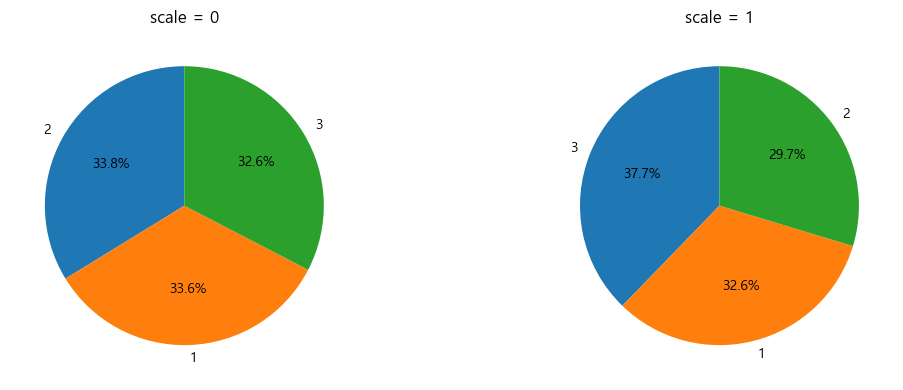

In [964]:
grouped_data = df_raw.groupby('scale')['fur_no'].value_counts()
scale_values = grouped_data.index.get_level_values('scale').unique()
fig, axes = plt.subplots(nrows=1, ncols=len(scale_values), figsize=(12, 4))

for i, scale_value in enumerate(scale_values):
    data = grouped_data[scale_value]
    axes[i].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'scale = {scale_value}')

plt.tight_layout()
plt.show()

위 결괏값에서 호기에 따라 불량/양품의 비율이 크게 다르다 생각지 않아 제거하기로 결정

In [965]:
df_raw.drop('fur_no', axis=1, inplace=True)

#### data frame 재확인

In [966]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rolling_date       1000 non-null   int32  
 1   scale              1000 non-null   int64  
 2   steel_kind         1000 non-null   int32  
 3   pt_thick           1000 non-null   int64  
 4   hsb                1000 non-null   int32  
 5   fur_input_row      1000 non-null   int32  
 6   fur_heat_time      1000 non-null   int64  
 7   fur_soak_time      1000 non-null   int64  
 8   fur_total_time     1000 non-null   int64  
 9   rolling_method     1000 non-null   int32  
 10  rolling_temp       1000 non-null   float64
 11  descaling_count    1000 non-null   int64  
 12  work_group         1000 non-null   int32  
 13  pt_area            1000 non-null   int64  
 14  rolling_temp_diff  1000 non-null   float64
 15  descaling_ratio    1000 non-null   float64
dtypes: float64(3), int32(6), 

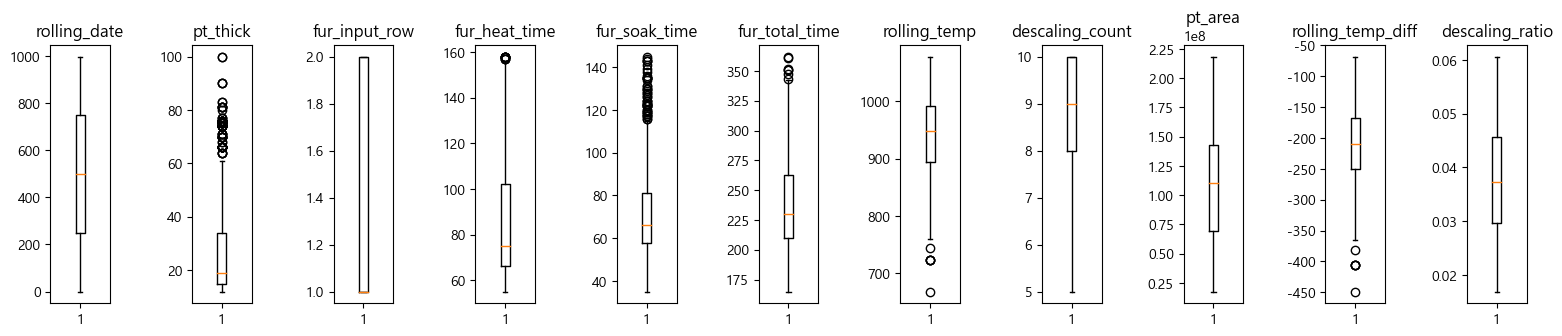

In [967]:
variables_boxplot = ['rolling_date', 'pt_thick', 'fur_input_row', 'fur_heat_time', 'fur_soak_time', 'fur_total_time', 'rolling_temp', 'descaling_count', 'pt_area', 'rolling_temp_diff', 'descaling_ratio']

fig, axes = plt.subplots(nrows=1, ncols=len(variables_boxplot), figsize=(16, 4))

for i, variable in enumerate(variables_boxplot):
    axes[i].boxplot(df_raw[variable])
    axes[i].set_title(variable)

# 서브플롯 간 간격 조정
plt.tight_layout(pad=3)

plt.show()

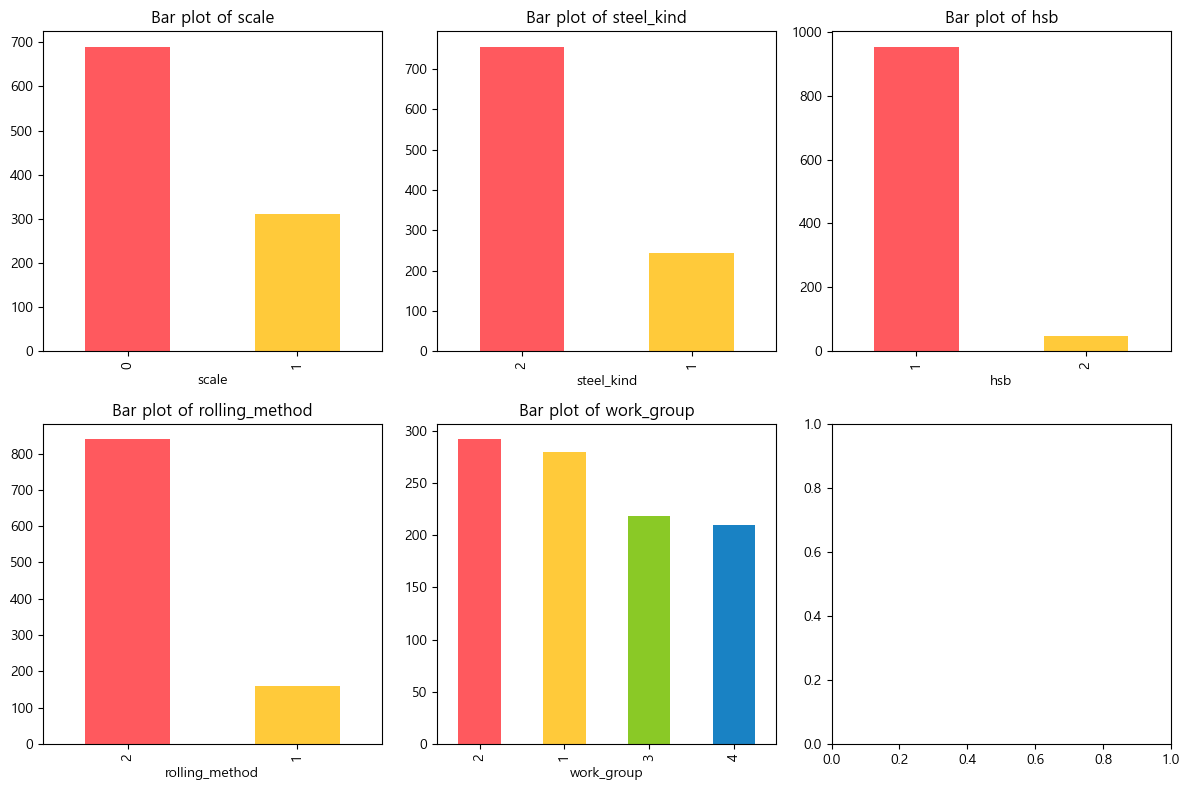

In [968]:
variables_barplot = ['scale', 'steel_kind', 'hsb', 'rolling_method', 'work_group']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

colors = ['#FF595E', '#FFCA3A', '#8AC926', '#1982C4', '#6A4C93', '#2A9D8F']  # 색상 리스트

for i, variable in enumerate(variables_barplot):
    value_counts = df_raw[variable].value_counts()
    value_counts.plot(kind='bar', ax=axes[i], color=colors)
    axes[i].set_title(f"Bar plot of {variable}")

# 서브플롯 간 간격 조정
plt.tight_layout()
plt.show()

In [977]:
def call_plot_hist(data, var):
    plt.hist(data[data["scale"] == 0][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["scale"] == 1][var], label = "불량", alpha = 0.5)
    plt.title(var)
    plt.legend()

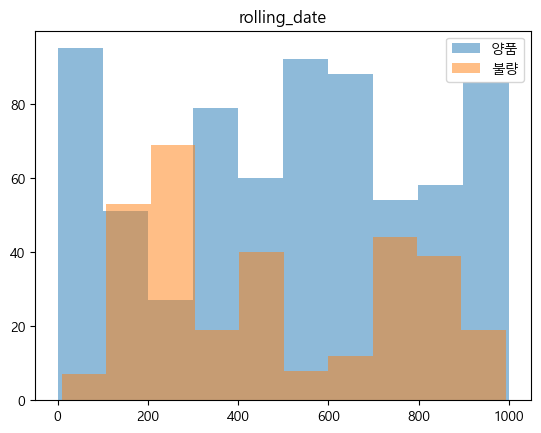

In [979]:
call_plot_hist(df_raw, "rolling_date")

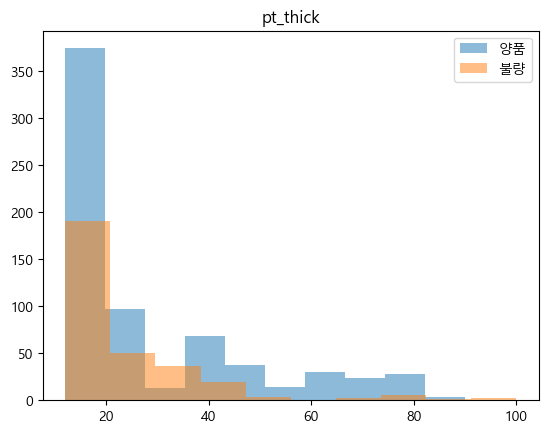

In [978]:
call_plot_hist(df_raw, "pt_thick")

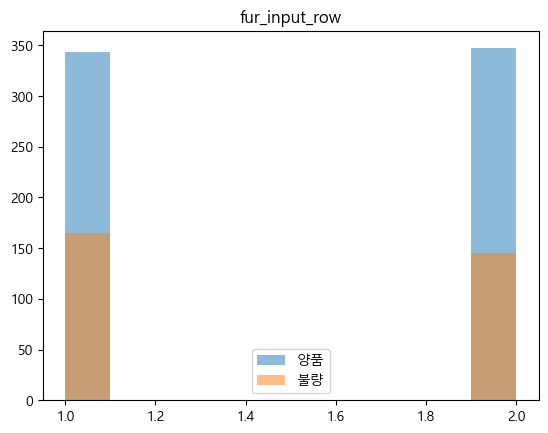

In [980]:
call_plot_hist(df_raw, "fur_input_row")

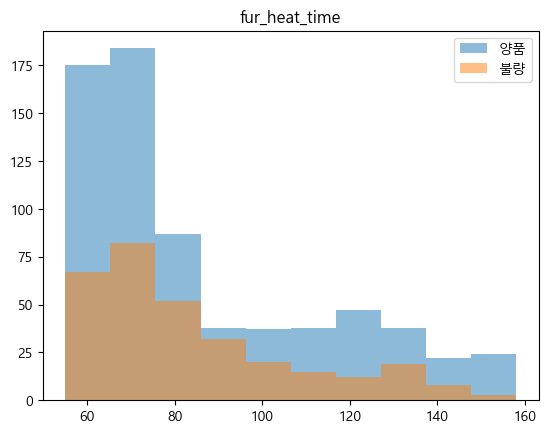

In [981]:
call_plot_hist(df_raw, "fur_heat_time")

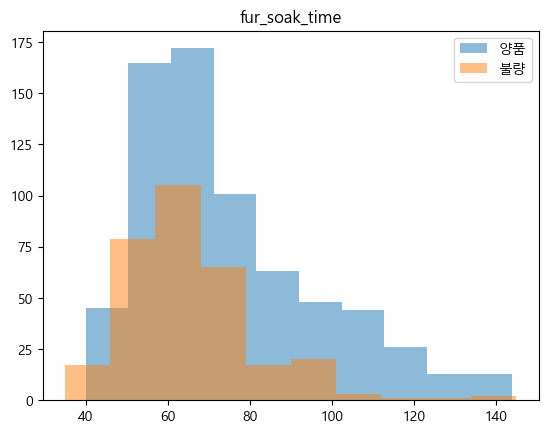

In [982]:
call_plot_hist(df_raw, "fur_soak_time")

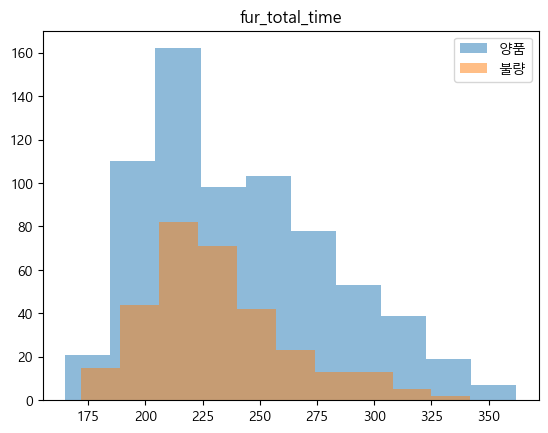

In [983]:
call_plot_hist(df_raw, "fur_total_time")

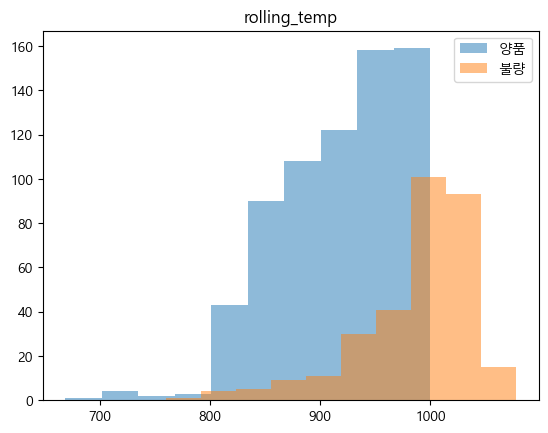

In [984]:
call_plot_hist(df_raw, "rolling_temp")

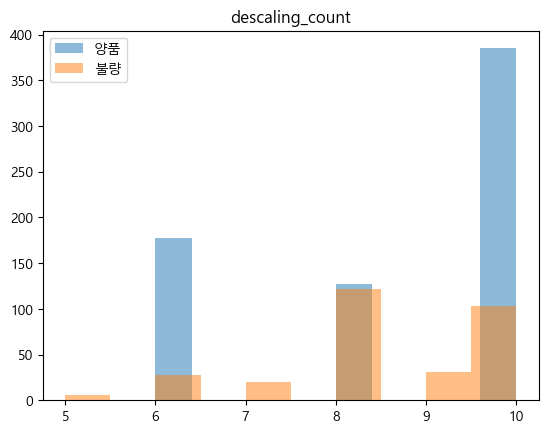

In [985]:
call_plot_hist(df_raw, "descaling_count")

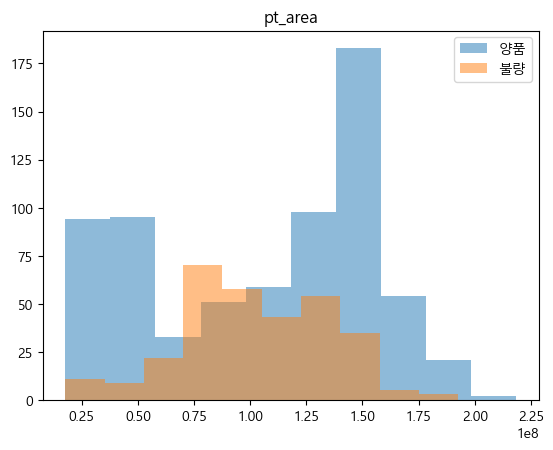

In [986]:
call_plot_hist(df_raw, "pt_area")

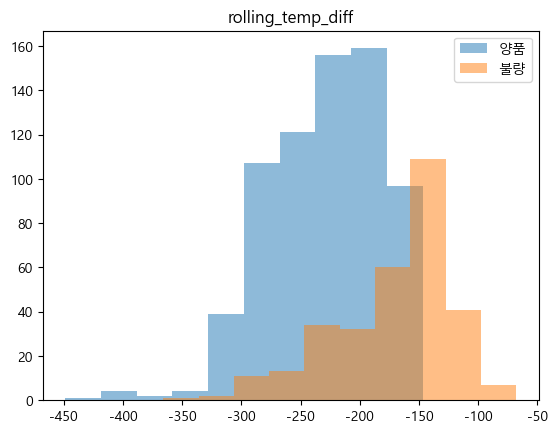

In [987]:
call_plot_hist(df_raw, "rolling_temp_diff")

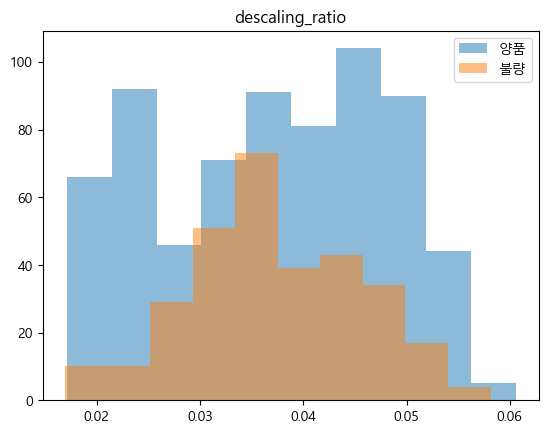

In [988]:
call_plot_hist(df_raw, "descaling_ratio")

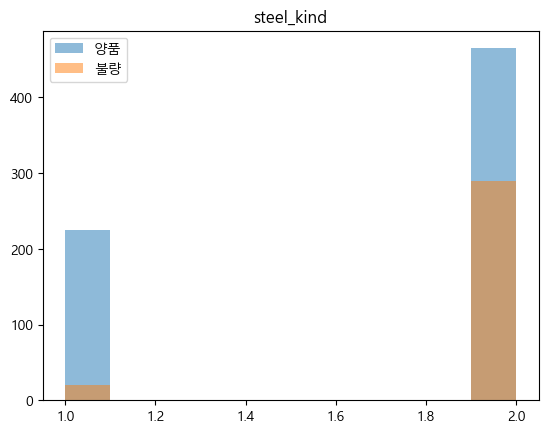

In [989]:
call_plot_hist(df_raw, "steel_kind")

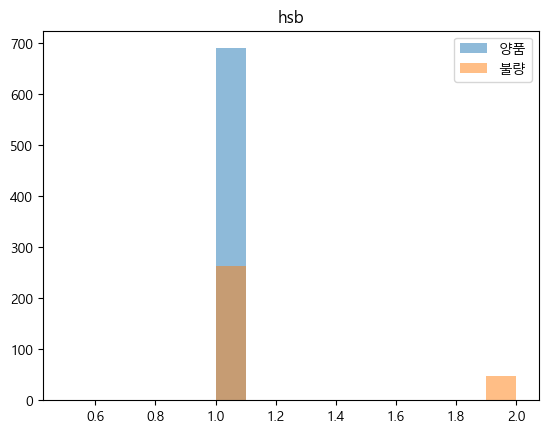

In [990]:
call_plot_hist(df_raw, "hsb")

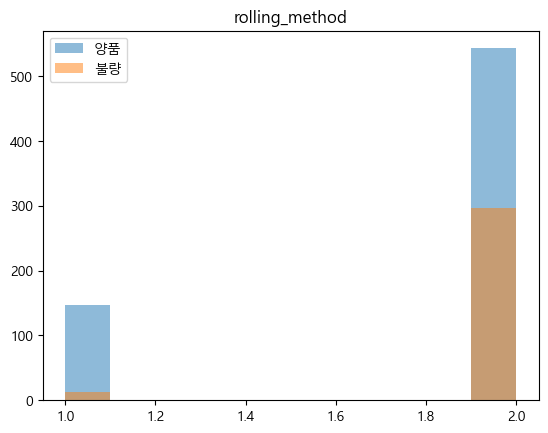

In [991]:
call_plot_hist(df_raw, "rolling_method")

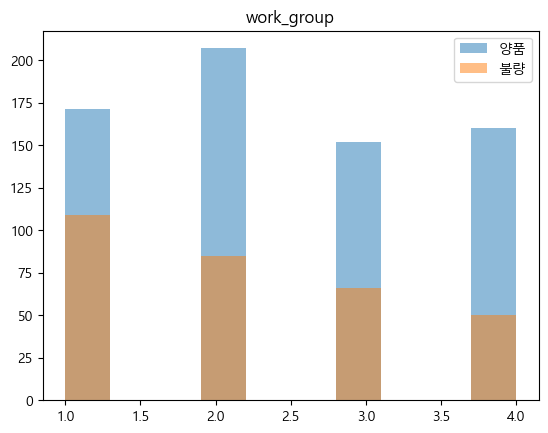

In [992]:
call_plot_hist(df_raw, "work_group")

#### 모델링

In [969]:
df_raw_y = df_raw['scale']
df_raw_x = df_raw.drop(['scale'], axis = 1, inplace = False)

In [970]:
# 데이터 분할(train, test 데이터 7:3 비율로 분할)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (700, 15)
train data Y size : (700,)
test data X size : (300, 15)
test data Y size : (300,)


In [971]:
from sklearn.tree import DecisionTreeClassifier #의사결정나무

#기본 옵션으로 모델 생성
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

#train 모델 정확도
print('Accuracy on training set : {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))

#test 모델 정확도
print('Accuracy on test set : {:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))


Accuracy on training set : 1.000
Accuracy on test set : 0.937


In [972]:
from sklearn.ensemble import RandomForestClassifier #랜덤포레스트

rf_uncustomized = RandomForestClassifier(random_state = 1234)
rf_uncustomized.fit(df_train_x,df_train_y)
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x,df_train_y)))
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x,df_test_y)))

Score on training set: 1.000
Score on test set: 0.943


In [973]:
from sklearn.ensemble import GradientBoostingClassifier #그래디언트 부스팅

tree_uncustom = GradientBoostingClassifier(random_state=1234)
tree_uncustom.fit(df_train_x, df_train_y)

print("train data의 score: {:.3f}".format(tree_uncustom.score(df_train_x, df_train_y)))
print("test data의 score: {:.3f}".format(tree_uncustom.score(df_test_x, df_test_y)))

train data의 score: 0.999
test data의 score: 0.973


In [974]:
from xgboost import XGBClassifier #XGBoost

xgboost_uncust = XGBClassifier(random_state=1234)
xgboost_uncust.fit(df_train_x, df_train_y)

print("train data의 score: {:.3f}".format(xgboost_uncust.score(df_train_x, df_train_y)))
print("test data의 score: {:.3f}".format(xgboost_uncust.score(df_test_x, df_test_y)))

train data의 score: 1.000
test data의 score: 0.970


In [975]:
from sklearn.svm import SVC

svm_uncustomized = SVC(random_state=1234)  # SVM 분류기 학습
svm_uncustomized.fit(df_train_x, df_train_y)
# train 모델 정확도
print('Accuracy on training set: {:.3f}'.format(svm_uncustomized.score(df_train_x, df_train_y)))
# test 모델 정확도
print('Accuracy on test set: {:.3f}'.format(svm_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 0.684
Accuracy on test set: 0.703


In [976]:
from sklearn.neural_network import MLPClassifier #인공신경망

nn_uncustomized = MLPClassifier(random_state=1234)
nn_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(nn_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(nn_uncustomized.score(df_test_x, df_test_y)))


Score on training set: 0.684
Score on test set: 0.703


위의 다양한 기본모델링을 통해, train, test score 모두에서 가장 높은 점수를 달성한 GradientBoosting을 선택하기로 결정했다. </br>
(다른 모델은 traain에 overfitting 되어있다고 판단)

#### GridSearchCV를 활용한 최적의 parameter찾기

In [994]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

tree_uncustom = GradientBoostingClassifier(random_state=1234)

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=tree_uncustom, param_grid=param_grid, cv=5)
grid_search.fit(df_train_x, df_train_y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("최적 매개변수: ", best_params)
print("최고 점수: {:.3f}".format(best_score))

최적 매개변수:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
최고 점수: 0.980


#### 결론도출 - 최종모델 선택

In [1004]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 최적의 매개변수로 모델 생성
final_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200, max_depth=3, random_state=1234)
final_model.fit(df_train_x, df_train_y)

y_pred = final_model.predict(df_test_x)

# Confusion matrix 출력
print("Confusion Matrix:")
print(confusion_matrix(df_test_y, y_pred))
print()

# 정확도 출력
accuracy = accuracy_score(df_test_y, y_pred)
print("Accuracy: {:.3f}".format(accuracy))
print()

# Classification report 출력
print("Classification Report:")
print(classification_report(df_test_y, y_pred))

Confusion Matrix:
[[208   3]
 [  5  84]]

Accuracy: 0.973

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       211
           1       0.97      0.94      0.95        89

    accuracy                           0.97       300
   macro avg       0.97      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300



최종모델의 결과는 다음과 같다. </br>
양품에 속하는 208개의 샘플이 정확하게 예측되었고 3개의 샘플이 오분류됐다.</br>
또한 불량에 대해서는 5개의 샘플이 오분류되었고 84개의 샘플이 정확하게 예측되었다. </br>

또한 정확도는 97%로, 전체 샘플 중 약 97.3%가 올바르게 분류되었다고 보여진다.</br>
precision, recall, f1-score 또한 높은 값을 갖고 있어서 데이터셋에 대한 일반화 성능이 좋다고 평가가 된다.

In [1005]:
v_feature_name = df_train_x.columns
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = final_model.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
9,rolling_temp,0.582
3,hsb,0.160
10,descaling_count,0.111
13,rolling_temp_diff,0.069
2,pt_thick,0.037
0,rolling_date,0.011
6,fur_soak_time,0.010
5,fur_heat_time,0.005
12,pt_area,0.004
7,fur_total_time,0.004


Text(0, 0.5, '설명변수')

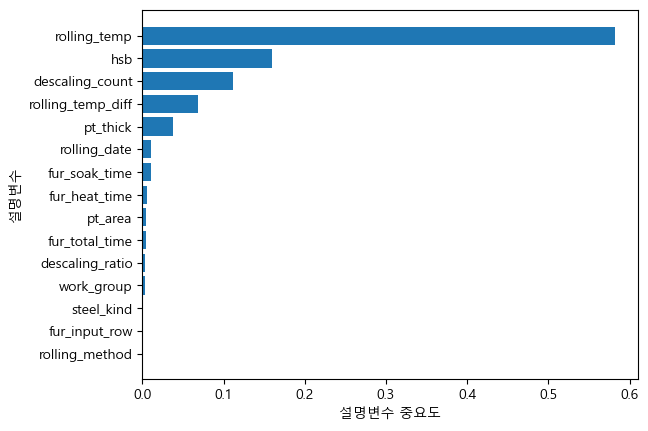

In [1006]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

위에서 나온 설명변수 중요도는 다음과 같다. </br>

1. rolling_temp(압연온도)가 가장 큰 중요도 값을 가지며, 0.582로 가장 영향력이 큰 변수임을 나타낸다.</br>
-> 압연은 철강을 필요한 두께와 너비로 압착하는 과정으로, 올바른 압연 온도를 유지하는 것은 철강의 품질과 성능을 결정하는 데 중요한 역할을 한다.</br>
따라서 압연 온도는 철강의 결정구조와 미세조직에 영향을 주며, 이는 스케일 분류에 큰 영향을 미친다고 생각이든다.</br>

2. hsb(HSB 적용여부)는 중요도 값이 0.160으로 두 번째로 영향력이 큰 변수이다.</br>
-> hsb는 철강 후판공정 중에 스케일을 제거하는 장치이다.</br>
HSB는 스케일을 제거하여 표면을 깨끗하게 유지하는 역할을 한다. 따라서 HSB가 적용된 경우 스케일 분류 결과에 긍정적인 영향을 미칠 수 있다.</br>

3. descaling_count(디스케일링 횟수)는 중요도 값이 0.111로 세 번째로 큰 영향력을 가지는 변수이다.</br>
-> 디스케일링은 철강 표면의 스케일을 제거하는 과정이다.</br>
디스케일링 횟수는 스케일 분류에 영향을 미치는데, 디스케일링을 더 많이 수행할수록 스케일의 제거 효과가 증가하여 스케일 분류 결과가 개선될 수 있다.</br>
따라서 적절한 디스케일링 횟수를 설정하는 것은 철강의 표면 품질을 향상시키는 데 도움이 될거라 생각이 든다.